In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras 
from keras import layers
import tensorflow_addons as tfa
import pandas as pd
import json
import zipfile
import os
import seaborn as sns
import random
import shutil
import time
from PIL import Image
from matplotlib import pyplot as plt
from keras.models import Sequential, Model
from keras.applications import InceptionV3, Xception, InceptionResNetV2
from keras.applications.resnet import preprocess_input
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator 
from keras.callbacks import ModelCheckpoint, TensorBoard 
import wandb
!mkdir output
!mkdir output/tmp-augmented-images/
random.seed(123)

/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


mkdir: output: File exists
mkdir: output/tmp-augmented-images/: File exists


In [2]:
def resample_data(move_from, move_to, cl, images_to_move=100):
  path = "./" + 'DATASET/data/pneumonia_data'

  classes = os.listdir(path + move_from)

  cl += '/'
  curr_path = path + move_from + cl
  for _, _, files in os.walk(curr_path):
    random.shuffle(files)
    files_to_move = files[:images_to_move]
    for fn in files_to_move:
      shutil.move(curr_path + fn, path + move_to + cl + fn)
      #print('Moved ' + curr_path + fn)

  print('Resampled Images')


move_from, move_to = 'train/', 'test/'
#resample_data(move_from, move_to, 'NORMAL', 200)
# Training images
print('Number of COVID training images:')
!ls DATASET/data/pneumonia_data/train/COVID_19/ | wc -l
print('Number of NORMAL training images:')
!ls DATASET/data/pneumonia_data/train/Normal/ | wc -l
print('Number of PNEUMONIA training images:')
!ls DATASET/data/pneumonia_data/train/Pneumonia// | wc -l
print()

# Validation images
print('Number of COVID training images:')
!ls DATASET/data/pneumonia_data/val/COVID_19/ | wc -l
print('Number of NORMAL validation images:')
!ls DATASET/data/pneumonia_data/val/Normal/ | wc -l
print('Number of PNEUMONIA validation images:')
!ls DATASET/data/pneumonia_data/val/Pneumonia/ | wc -l
print()


# Test images
#resample_data('test/', 'val/', 'PNEUMONIA', 2690)
print('Number of COVID training images:')
!ls DATASET/data/pneumonia_data/test/COVID_19/ | wc -l
print('Number of NORMAL test images:')
!ls DATASET/data/pneumonia_data/test/Normal/ | wc -l
print('Number of PNEUMONIA test images:')
!ls DATASET/data/pneumonia_data/test/Pneumonia/ | wc -l

Number of COVID training images:
    1000
Number of NORMAL training images:
    2925
Number of PNEUMONIA training images:
    3772

Number of COVID training images:
     171
Number of NORMAL validation images:
     235
Number of PNEUMONIA validation images:
     765

Number of COVID training images:
     110
Number of NORMAL test images:
     110
Number of PNEUMONIA test images:
     120


5


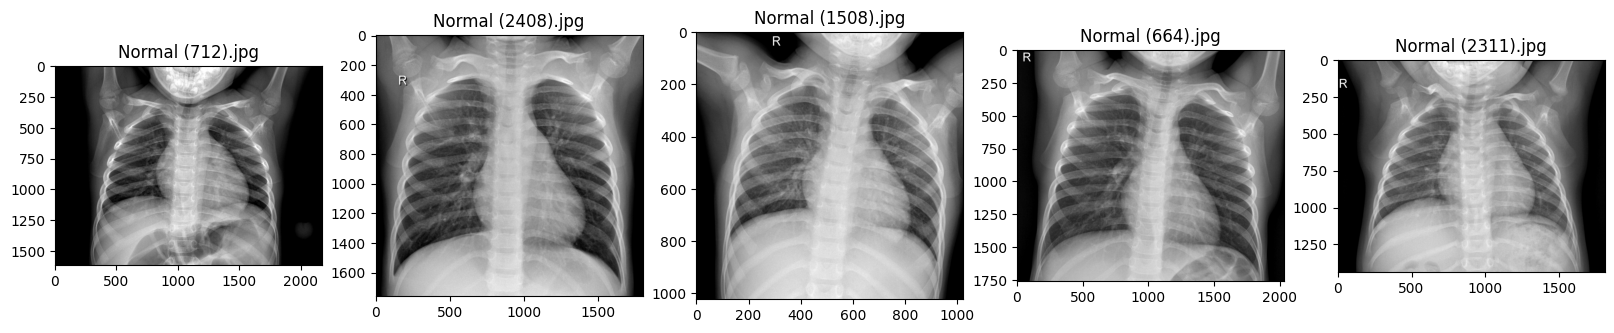

In [3]:
def viewImagesFromDir(path, num=5):
  #Display num random images from dataset. Rerun cell for new random images. The images are only single-channel

  img_paths_visualise = sorted(
        os.path.join(path, fname)
        for fname in os.listdir(path)
        if fname.endswith(".jpg")
  )

  random.shuffle(img_paths_visualise)

  fig, ax = plt.subplots(1, num, figsize=(20, 10))
  print(num)
  for i in range(num):
    ax[i].imshow(Image.open(img_paths_visualise[i]))
    index = img_paths_visualise[i].rfind('/') + 1
    ax[i].title.set_text(img_paths_visualise[i][index:])

  fig.canvas.draw()
  time.sleep(1)


viewImagesFromDir('DATASET/data/pneumonia_data/train/Normal/', num=5)

In [4]:
base_dir = 'DATASET/data/pneumonia_data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

# Directory with our training covid 19 pictures
train_covid_dir = os.path.join(train_dir, 'COVID_19')

# Directory with our training normal pictures
train_normal_dir = os.path.join(train_dir, 'NORMAL')

# Directory with our training pneumonia pictures
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

# Directory with our validation covid 19 pictures
validation_covid_dir = os.path.join(validation_dir, 'COVID_19')

# Directory with our validation normal pictures
validation_normal_dir = os.path.join(validation_dir, 'NORMAL')

# Directory with our validation pneumonia pictures
validation_pneumonia_dir = os.path.join(validation_dir, 'PNEUMONIA')

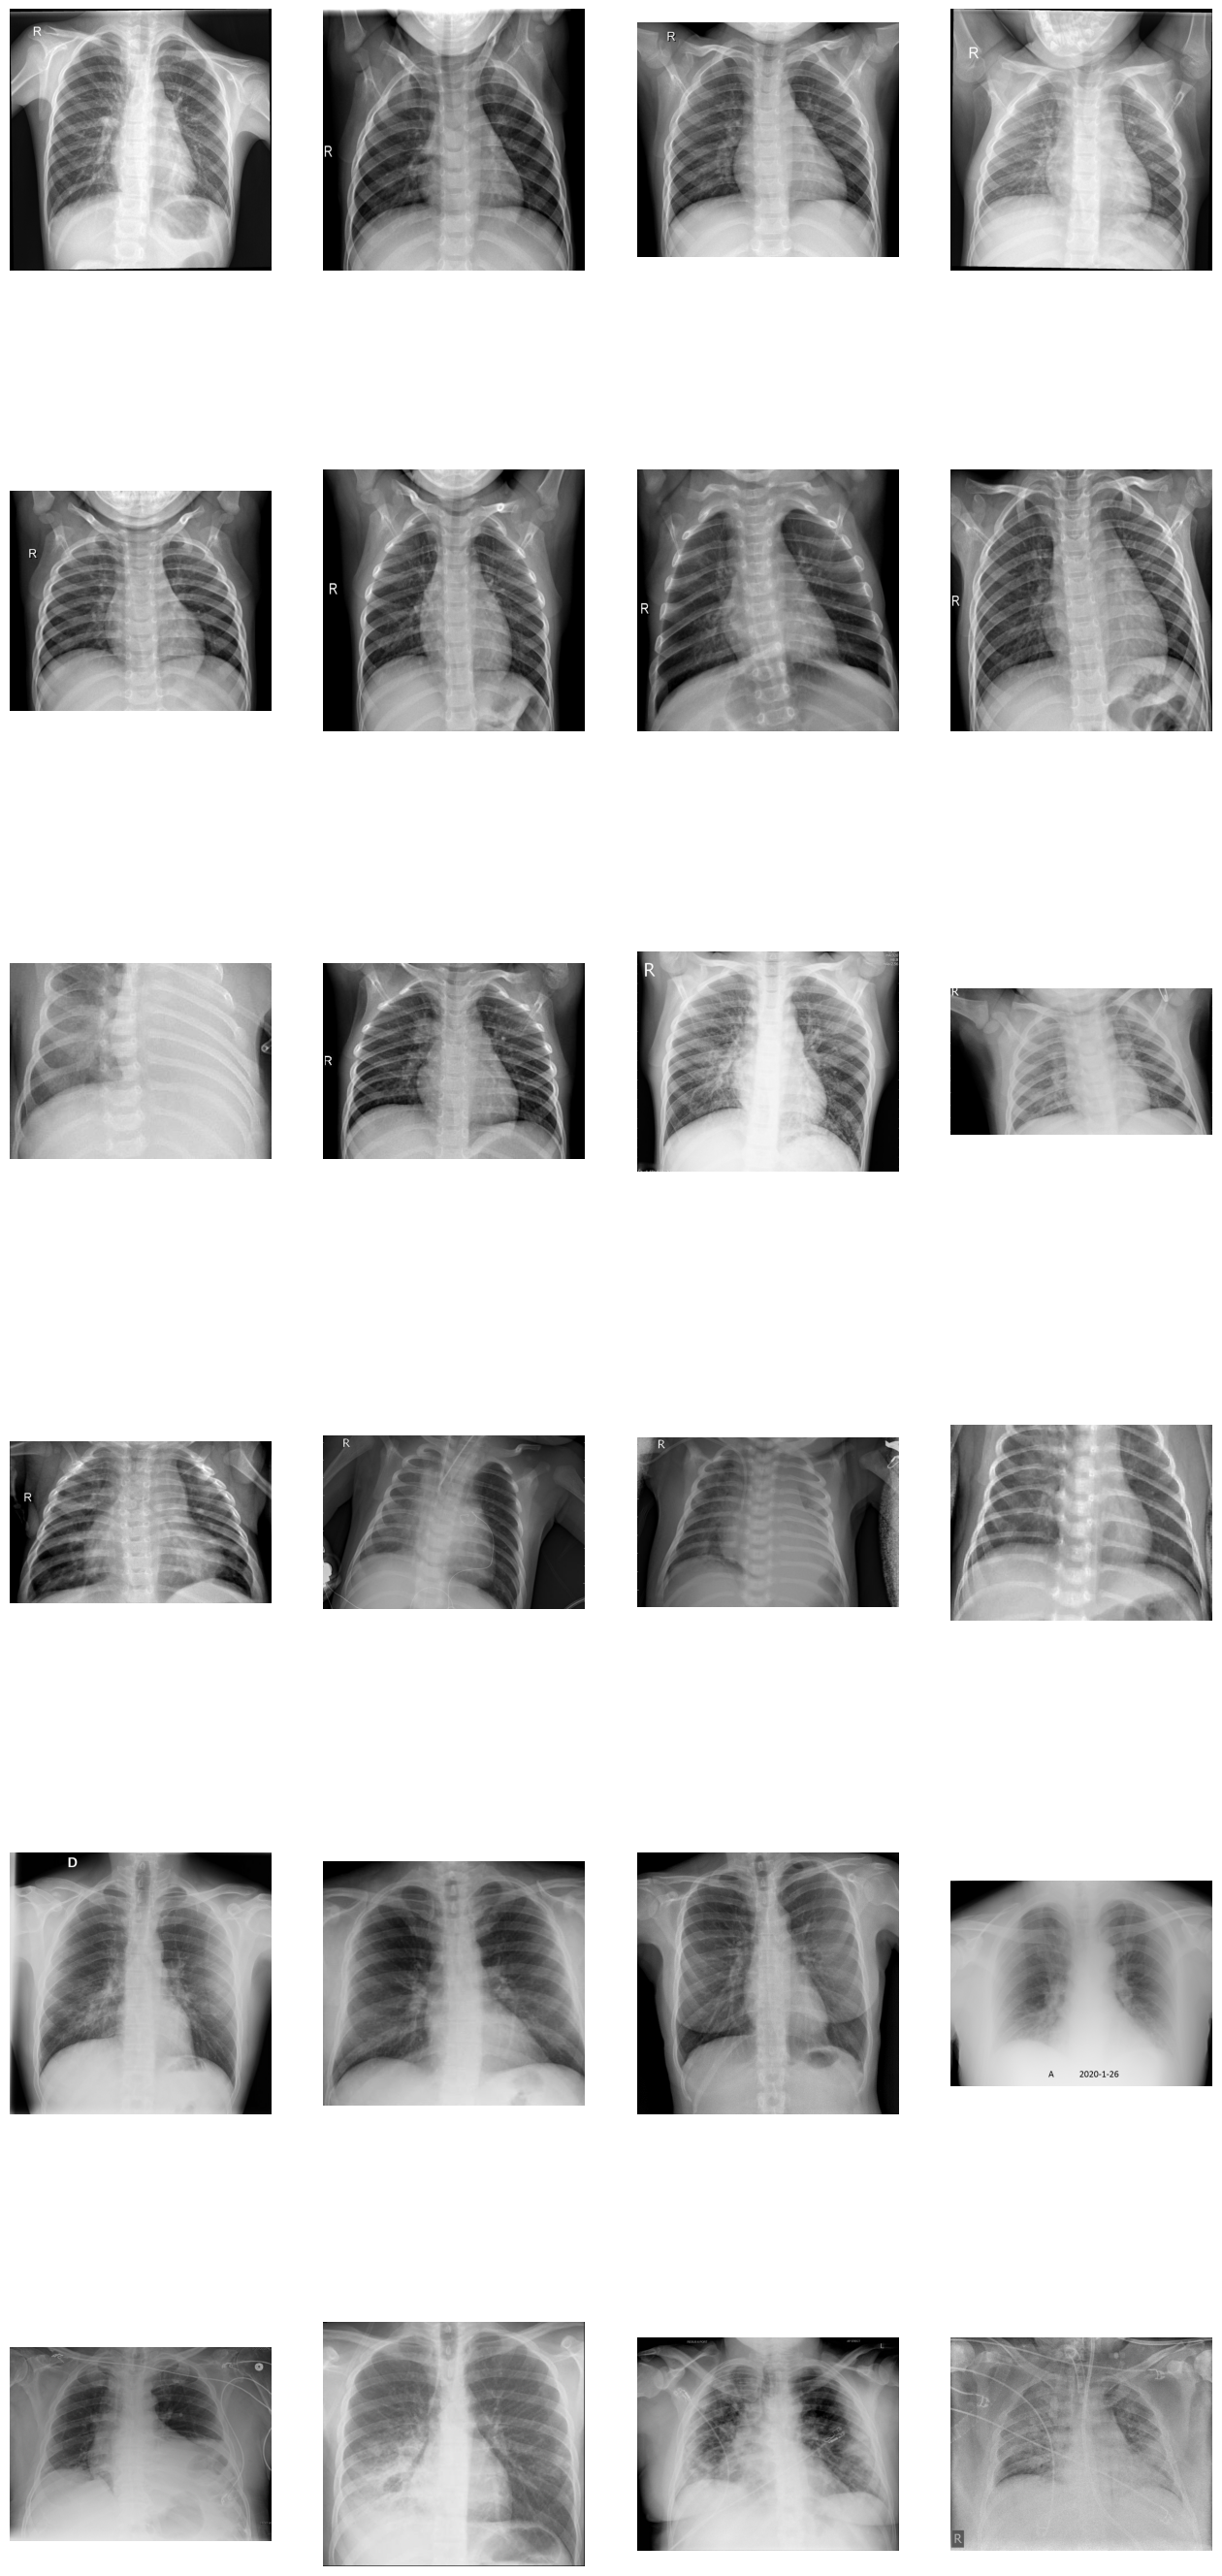

In [5]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
nrows = 6
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*6)
pic_index = 100
train_covid_fnames = os.listdir( train_covid_dir)
train_normal_fnames = os.listdir( train_normal_dir )
train_pneumonia_fnames = os.listdir( train_pneumonia_dir )

next_covid_pix = [os.path.join(train_covid_dir, fname)
                for fname in train_covid_fnames[ pic_index-8:pic_index]
               ]
next_normal_pix = [os.path.join(train_normal_dir, fname)
                for fname in train_normal_fnames[ pic_index-8:pic_index]
               ]

next_pneumonia_pix = [os.path.join(train_pneumonia_dir, fname)
                for fname in train_pneumonia_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_normal_pix+next_pneumonia_pix+next_covid_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [6]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [7]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 32, class_mode = 'categorical', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 32, class_mode = 'categorical', target_size = (224, 224))


Found 7697 images belonging to 3 classes.
Found 1171 images belonging to 3 classes.


In [8]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [9]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(3, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

# Use the legacy Keras optimizer
optimizer_legacy = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001)

model.compile(optimizer = optimizer_legacy, loss = 'categorical_crossentropy', metrics = ['acc'])

In [13]:
#Import necessary libraries
from keras.callbacks import EarlyStopping, CSVLogger

# Add CSVLogger to save training history
csv_logger = CSVLogger('training_vgg.log', append=True, separator=';')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=20,  # Adjust the number of epochs as needed
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[csv_logger, early_stopping]
)

# Save the model in the native Keras format
model.save('best_vgg_model.keras')

Epoch 1/20
100/100 [==============================] - 231s 2s/step - loss: 0.5419 - accuracy: 0.8216 - val_loss: 0.2604 - val_accuracy: 0.9172
Epoch 2/20
100/100 [==============================] - 230s 2s/step - loss: 0.4612 - accuracy: 0.8303 - val_loss: 0.3926 - val_accuracy: 0.8224
Epoch 3/20
100/100 [==============================] - 231s 2s/step - loss: 0.3939 - accuracy: 0.8562 - val_loss: 0.3175 - val_accuracy: 0.8796
Epoch 4/20
100/100 [==============================] - 224s 2s/step - loss: 0.3507 - accuracy: 0.8728 - val_loss: 0.3800 - val_accuracy: 0.8651
Epoch 5/20
100/100 [==============================] - 224s 2s/step - loss: 0.3450 - accuracy: 0.8813 - val_loss: 0.2987 - val_accuracy: 0.9018
Epoch 6/20
100/100 [==============================] - 223s 2s/step - loss: 0.3625 - accuracy: 0.8722 - val_loss: 0.2383 - val_accuracy: 0.9163
Epoch 7/20
100/100 [==============================] - 225s 2s/step - loss: 0.3561 - accuracy: 0.8716 - val_loss: 0.3535 - val_accuracy: 0.8813

In [14]:
history = history.history

In [15]:
history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [16]:
train_loss, val_loss = history['loss'], history['val_loss']
train_acc, val_acc = history['accuracy'], history['val_accuracy']

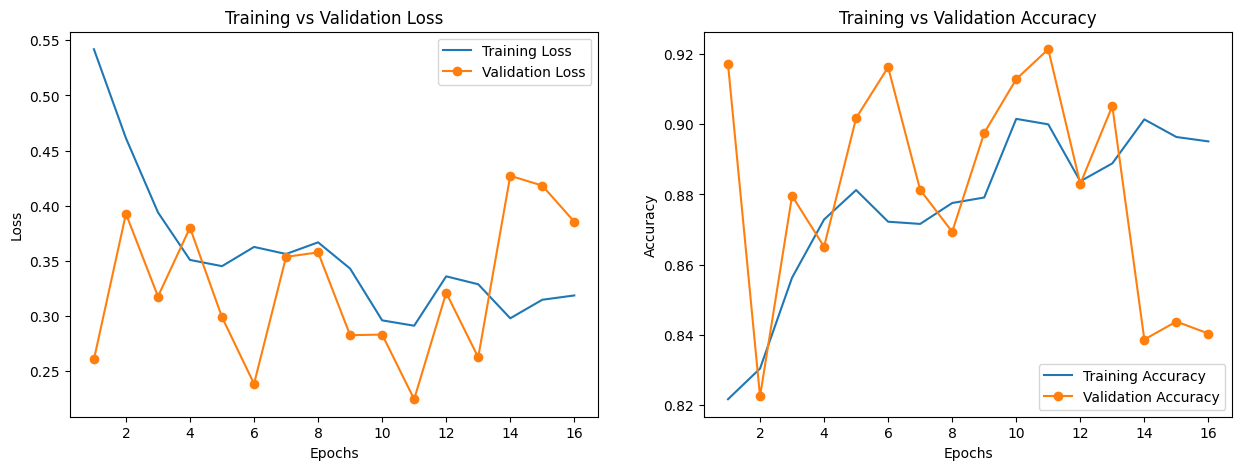

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
epoch_runs = [i+1 for i in range(16)]

ax1.plot(epoch_runs, train_loss, label='Training Loss')
ax1.plot(epoch_runs, val_loss, label='Validation Loss', marker='o')
ax1.set(title='Training vs Validation Loss', xlabel='Epochs',ylabel='Loss')
ax1.legend()

ax2.plot(epoch_runs, train_acc, label='Training Accuracy')
ax2.plot(epoch_runs, val_acc, label='Validation Accuracy', marker='o')
ax2.set(title='Training vs Validation Accuracy', xlabel='Epochs',ylabel='Accuracy')
ax2.legend()

plt.show()

In [19]:
test_dir = 'DATASET/data/pneumonia_data/test'
# Assuming you have a separate test dataset stored in the variable test_dir
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=32, class_mode='categorical', target_size=(224,224))

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

Found 340 images belonging to 3 classes.
11/11 [==============================] - 18s 2s/step - loss: 0.2233 - accuracy: 0.9265
Test Loss: 0.22331158816814423
Test Accuracy: 0.9264705777168274


37/37 [==============================] - 60s 2s/step


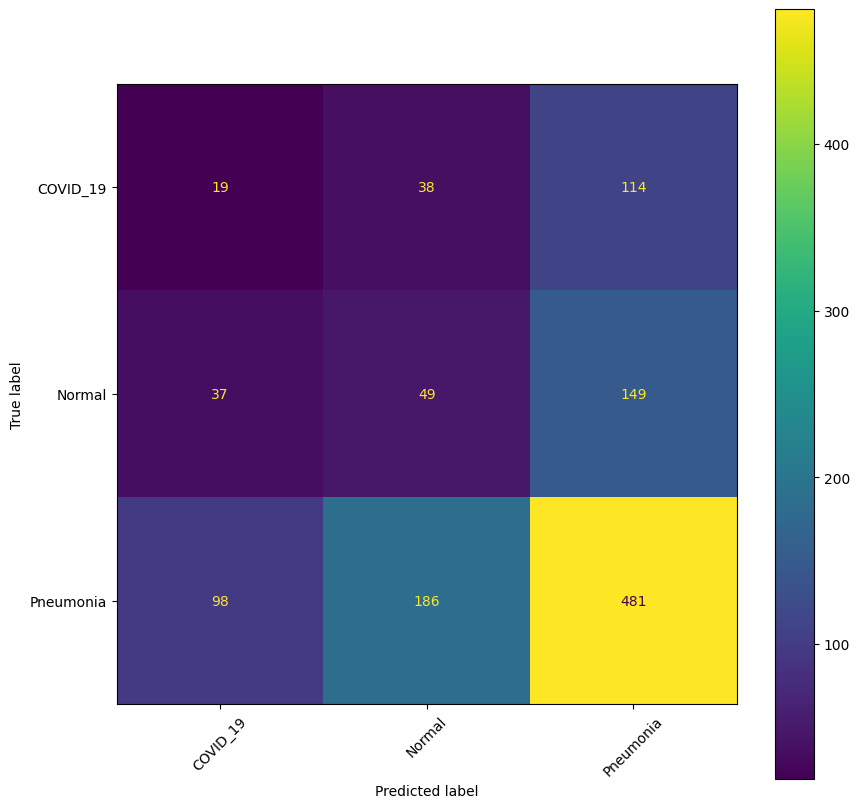

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
validation_steps = validation_generator.samples // validation_generator.batch_size
predictions = model.predict(validation_generator, steps=validation_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels from the validation generator
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Predict the classes for the entire validation dataset
validation_generator.reset()  # Ensure generator starts from the beginning
predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Ensure the number of predictions matches the number of samples
predicted_classes = predicted_classes[:len(true_classes)]

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
cmd.plot(ax=ax)
plt.xticks(rotation=45)
plt.show()

In [21]:
import pandas as pd

# Extract classes
classes = list(test_generator.class_indices.keys())

# Calculate metrics
tn = np.diag(cm)
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = cm.sum() - (fp + fn + tn)

confusion_matrix_df = pd.DataFrame({
    'Class': classes,
    'TN': tn,
    'FP': fp,
    'FN': fn,
    'TP': tp
})

print('Confusion Matrix Metrics:')
print(confusion_matrix_df)

Confusion Matrix Metrics:
       Class   TN   FP   FN   TP
0   COVID_19   19  135  152  865
1     Normal   49  224  186  712
2  Pneumonia  481  263  284  143


37/37 [==============================] - 61s 2s/step


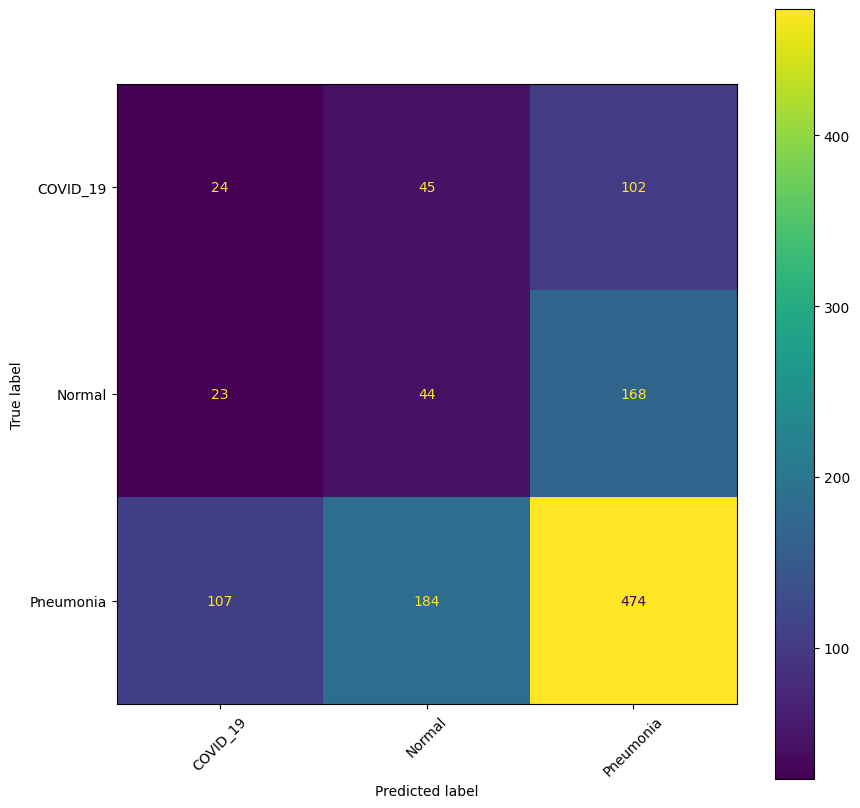

Class: COVID_19
Precision: 0.15584415584415584
Recall: 0.14035087719298245
F1-score: 0.1476923076923077
---
Class: Normal
Precision: 0.16117216117216118
Recall: 0.18723404255319148
F1-score: 0.1732283464566929
---
Class: Pneumonia
Precision: 0.6370967741935484
Recall: 0.6196078431372549
F1-score: 0.6282306163021869
---


In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming validation_generator, model, and other related variables are already defined

# Get the true labels from the validation generator
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Predict the classes for the entire validation dataset
validation_generator.reset()  # Ensure generator starts from the beginning
predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Ensure the number of predictions matches the number of samples
predicted_classes = predicted_classes[:len(true_classes)]

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
cmd.plot(ax=ax)
plt.xticks(rotation=45)
plt.show()

# Calculate precision, recall, and f1-score for each class
precision_per_class = precision_score(true_classes, predicted_classes, average=None)
recall_per_class = recall_score(true_classes, predicted_classes, average=None)
f1_per_class = f1_score(true_classes, predicted_classes, average=None)

# Display the precision, recall, and F1-score for each class
for i, label in enumerate(class_labels):
    print(f'Class: {label}')
    print(f'Precision: {precision_per_class[i]}')
    print(f'Recall: {recall_per_class[i]}')
    print(f'F1-score: {f1_per_class[i]}')
    print('---')

